In [1]:
import pickle
import matplotlib.pyplot as plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle
from gplearn.genetic import SymbolicClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from io import StringIO
from IPython.display import Image

In [ ]:
def file_name(name,path):
    import pandas as pd
    global data
    data = pd.read_csv(name)
    data.to_csv(path+"/data.csv")
    print(data)
    return data

In [ ]:
def heatmap_before(path):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    featureData=data.iloc[:,:]
    global corMat
    corMat = pd.DataFrame(featureData.corr())  #corr 求相关系数矩阵
    corMat.to_csv(path+'/heatmap-before.csv')
    plt.figure(figsize=(20, 30))
    sns.heatmap(corMat, annot=False, vmax=1, square=True, cmap="Blues",linewidths=0)
    plt.savefig(path+'/heatmap-before.png', dpi=300, bbox_inches = 'tight')
    plt.close()
    return

In [ ]:
def feature_rfe_select1(remain_number,path):
    # 使用随机森林的rfe:RandomForestRegressor()
    from sklearn import preprocessing
    from sklearn.feature_selection import RFE, RFECV
    from sklearn.ensemble import RandomForestRegressor
    import csv
    import numpy as np

    # 输入数据归一化
    X = data.values[:, :-1]
    for i in range(X.shape[1]):
        X[:, [i]] = preprocessing.MinMaxScaler().fit_transform(X[:, [i]])
    y = data.values[:, -1]  # 目标数值

    # rfe步骤
    model = RandomForestRegressor()
    rfe = RFE(estimator=model, n_features_to_select=remain_number, step=1)
    rfe_X = rfe.fit_transform(X, y)
    print("特征是否被选中：\n", rfe.support_)                                          # ndarray
    print("获取的数据特征尺寸:", rfe_X.shape)                                           # tuple
    list1 = rfe.support_.tolist()

    # 打印rfe后的特征，但可能包含空值
    import pandas as pd
    Features_0 = pd.DataFrame(data=data.iloc[:, :-1].columns, columns=['Features'])
    Features_0
    Features_rfe = pd.DataFrame(data=rfe.support_, columns=['whether selected'])
    Features_rfe
    #     pd.options.display.max_rows=None
    p = pd.concat([Features_0, Features_rfe], axis=1)
    q = p[p['whether selected']>0]
    r = q.reset_index(drop=True)
    global s_rfe
    s_rfe = pd.DataFrame(data=data,columns=r.Features.values)
    global target
    target = pd.DataFrame(data=data.iloc[:,-1])
    # target = pd.DataFrame(data, columns=['Potential (v)'])
    global data_rfe
    data_rfe = pd.concat([s_rfe,target], axis=1)
    print("最后的特征s_rfe:", r.Features.values)                                        # ndarray
    print("目标target:", target)
    print("rfe后的总数据data_rfe:", data_rfe)

    list2 = r.Features.values.tolist()

    # print全输出
    with open(path + "/data.txt", "w") as f:
        #f.write("特征是否被选中：\n")
        f.write("Whether the feature is selected:\n")
        for i in range(len(list1)):
            f.write(str(list1[i])+' ')
        #f.write("\n获取的数据特征尺寸：\n")
        f.write("\nAcquired data feature size:\n")
        f.write('(%s,%s)' % rfe_X.shape)
        #f.write("\n最后的特征s_rfe：\n")
        f.write("\nS_rfe(Final feature)：\n")
        for i in range(len(list2)):
            f.write(str(list2[i]) + '\n')
    target.to_csv(path + "/target.csv")
    data_rfe.to_csv(path + "/data_rfe.csv")
    return target,data_rfe

#4.1 画rfe特征选择后的热图
def heatmap_afterRFE(path):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    data_rfe_corMat = pd.DataFrame(data_rfe.corr())  #corr 求相关系数矩阵
    data_rfe_corMat.to_csv(path+'/heatmap-afterRFE.csv')
    plt.figure(figsize=(20, 30))
    sns.heatmap(data_rfe_corMat, annot=False, vmax=1, square=True, cmap="Blues",linewidths=0)
    plt.savefig(path+'/heatmap-afterRFE.png', dpi=300, bbox_inches = 'tight')
    plt.close()

In [42]:
dataset= r'TrainTest_classification_minus0.1_minus3_Feature_selection.csv'
data=pd.DataFrame(pd.read_csv(dataset))

In [43]:
X = data.values[:, :-1]
y = data.values[:, -1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1)


for i in range(X_train.shape[1]):
    X_train[:, [i]] = preprocessing.MinMaxScaler().fit_transform(X_train[:, [i]])



for i in range(X_test.shape[1]):
    X_test[:, [i]] = preprocessing.MinMaxScaler().fit_transform(X_test[:, [i]])

In [44]:
feature_names = list(data.columns[:-1])

In [45]:
# # 定义符号回归模型，并使用训练数据拟合模型
# reg = SymbolicRegressor(population_size=5000, generations=100, verbose=1,
#                          function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 
#                                        'inv', 'max', 'min', 'sin', 'cos', 'tan'],
#                          metric='mean absolute error', stopping_criteria=0.001,
#                          random_state=0)
# reg.fit(X_train, y_train)

# 创建符号分类器
reg = SymbolicClassifier(population_size=5000, generations=30, tournament_size=20,
                         stopping_criteria=0.0, const_range=(-1.0, 1.0), function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 
                                        'inv', 'max', 'min', 'sin', 'cos', 'tan'], verbose=1)
reg.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.11          1.09377        6         0.581045              N/A     39.27s
   1     6.33         0.772933       12         0.542701              N/A     46.83s
   2     6.29         0.756446        8         0.535464              N/A     38.80s
   3     7.60         0.795363       23         0.518624              N/A     38.32s
   4    10.00         0.810464       17         0.502258              N/A     37.88s
   5    12.16          0.80107       18         0.476797              N/A     37.44s
   6    12.73         0.865817       18         0.476797              N/A     35.74s
   7    15.39         0.823571       26          0.46189              N/A     35.40s
   8    19.67         0.755476       26         0.457028              N/A  

SymbolicClassifier(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                 'abs', 'neg', 'inv', 'max', 'min', 'sin',
                                 'cos', 'tan'],
                   generations=30, population_size=5000, verbose=1)

In [46]:
print(set(str(reg._program).split()))

{'sub(X10,', 'X5),', 'cos(mul(sqrt(div(div(sqrt(sqrt(X3)),', 'sqrt(log(min(X5,', 'tan(neg(cos(mul(add(X0,', 'X3)))),', 'sqrt(log(X11))),', 'X11)),', 'log(X5))))))),', 'add(X0,', 'X2),', 'X10))),', 'sqrt(X3)),', 'mul(sqrt(div(add(X0,', 'X2))))', 'sub(add(mul(mul(sqrt(div(mul(sqrt(div(log(min(X0,', 'X4))),', 'mul(X10,'}


Confusion Matrix:
[[129   7]
 [ 30  26]]


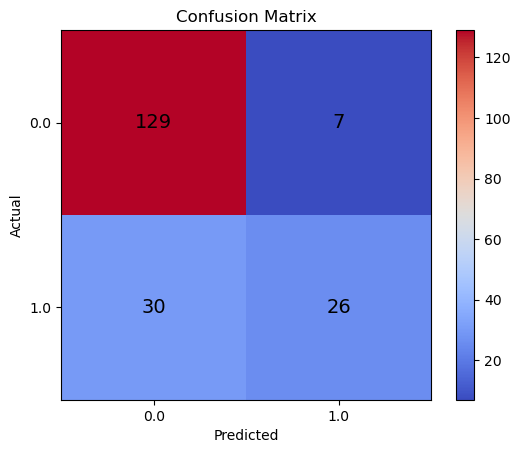

In [47]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prediction on test set
y_pred = reg.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.imshow(cm, cmap="coolwarm")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(len(set(y))), set(y))
plt.yticks(np.arange(len(set(y))), set(y))

# Adding text to the confusion matrix cells with larger font size
for i in range(len(set(y))):
    for j in range(len(set(y))):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)
plt.savefig('test.png')
plt.show()

Confusion Matrix:
[[299  10]
 [ 39 100]]


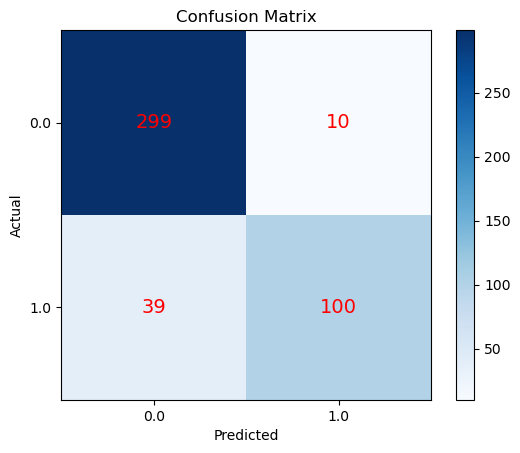

In [48]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prediction on test set
y_pred = reg.predict(X_train)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(len(set(y))), set(y))
plt.yticks(np.arange(len(set(y))), set(y))

# Adding text to the confusion matrix cells with larger font size
for i in range(len(set(y))):
    for j in range(len(set(y))):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=14)
plt.savefig('train.png')
plt.show()

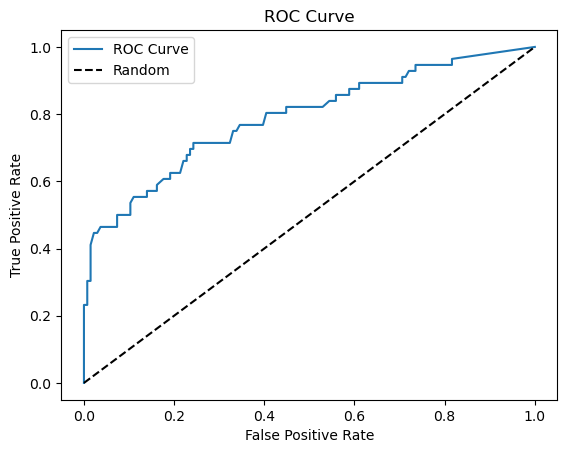

Accuracy: 0.8072916666666666


In [49]:
# ROC Curve
y_probs = reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plotting ROC Curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('test_ROC.png')
plt.show()

# Accuracy
accuracy = reg.score(X_test, y_test)
print("Accuracy:", accuracy)


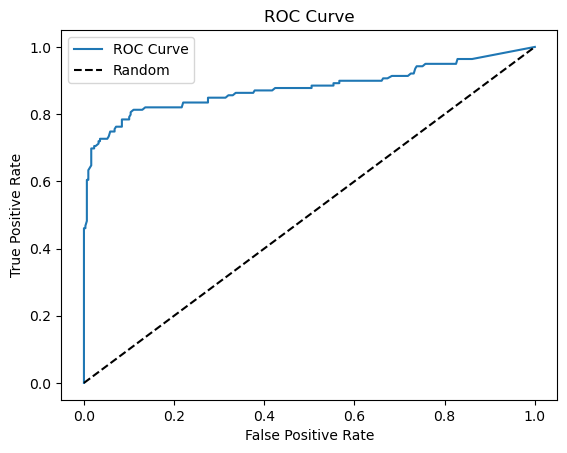

Accuracy: 0.890625


In [50]:
# ROC Curve
y_probs = reg.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs)

# Plotting ROC Curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('train_ROC.png')
plt.show()

# Accuracy
accuracy = reg.score(X_train, y_train)
print("Accuracy:", accuracy)


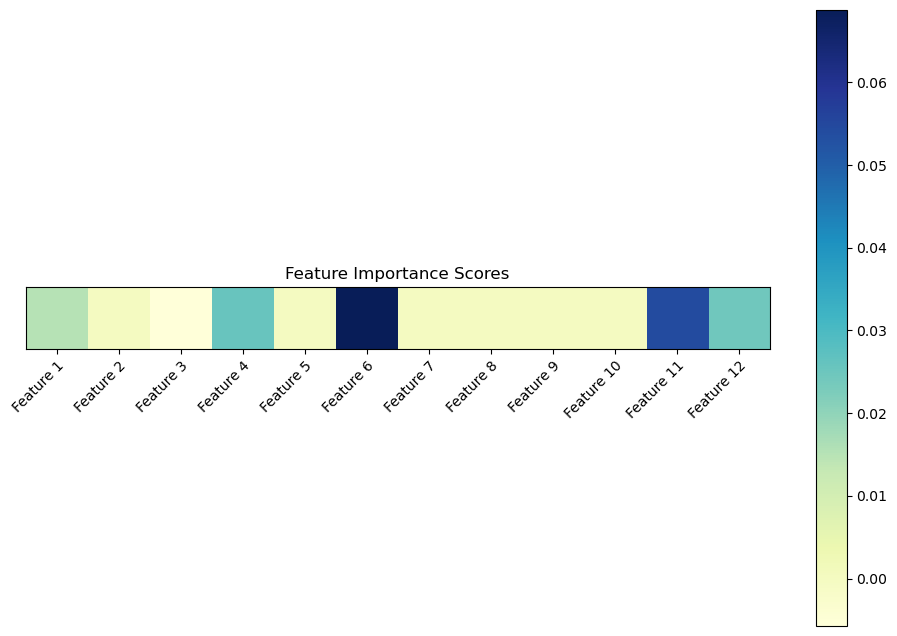

In [51]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Get feature-importance scores
result = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=0)

# Create a heatmap
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(result.importances_mean.reshape(1, -1), cmap='YlGnBu')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(result.importances_mean)))
ax.set_xticklabels([f"Feature {i+1}" for i in range(len(result.importances_mean))])
ax.set_yticks([])

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set plot title and show plot
ax.set_title("Feature Importance Scores")
plt.savefig('Feature_importance.png')
plt.show()
# 这个代码会创建一个热力图，显示特征重要性分数。
# x轴显示特征编号，每个单元格的颜色表示该特征的重要性分数，颜色越亮，意味着该特征对该模型越重要。

In [52]:
import pickle

# 保存训练好的模型
with open('symbol_classification.pkl', 'wb') as file:
    pickle.dump(reg, file)

In [53]:
# # 加载保存的模型
# with open('有NLP_symbol_classifier.pkl', 'rb') as file:
#     reg = pickle.load(file)

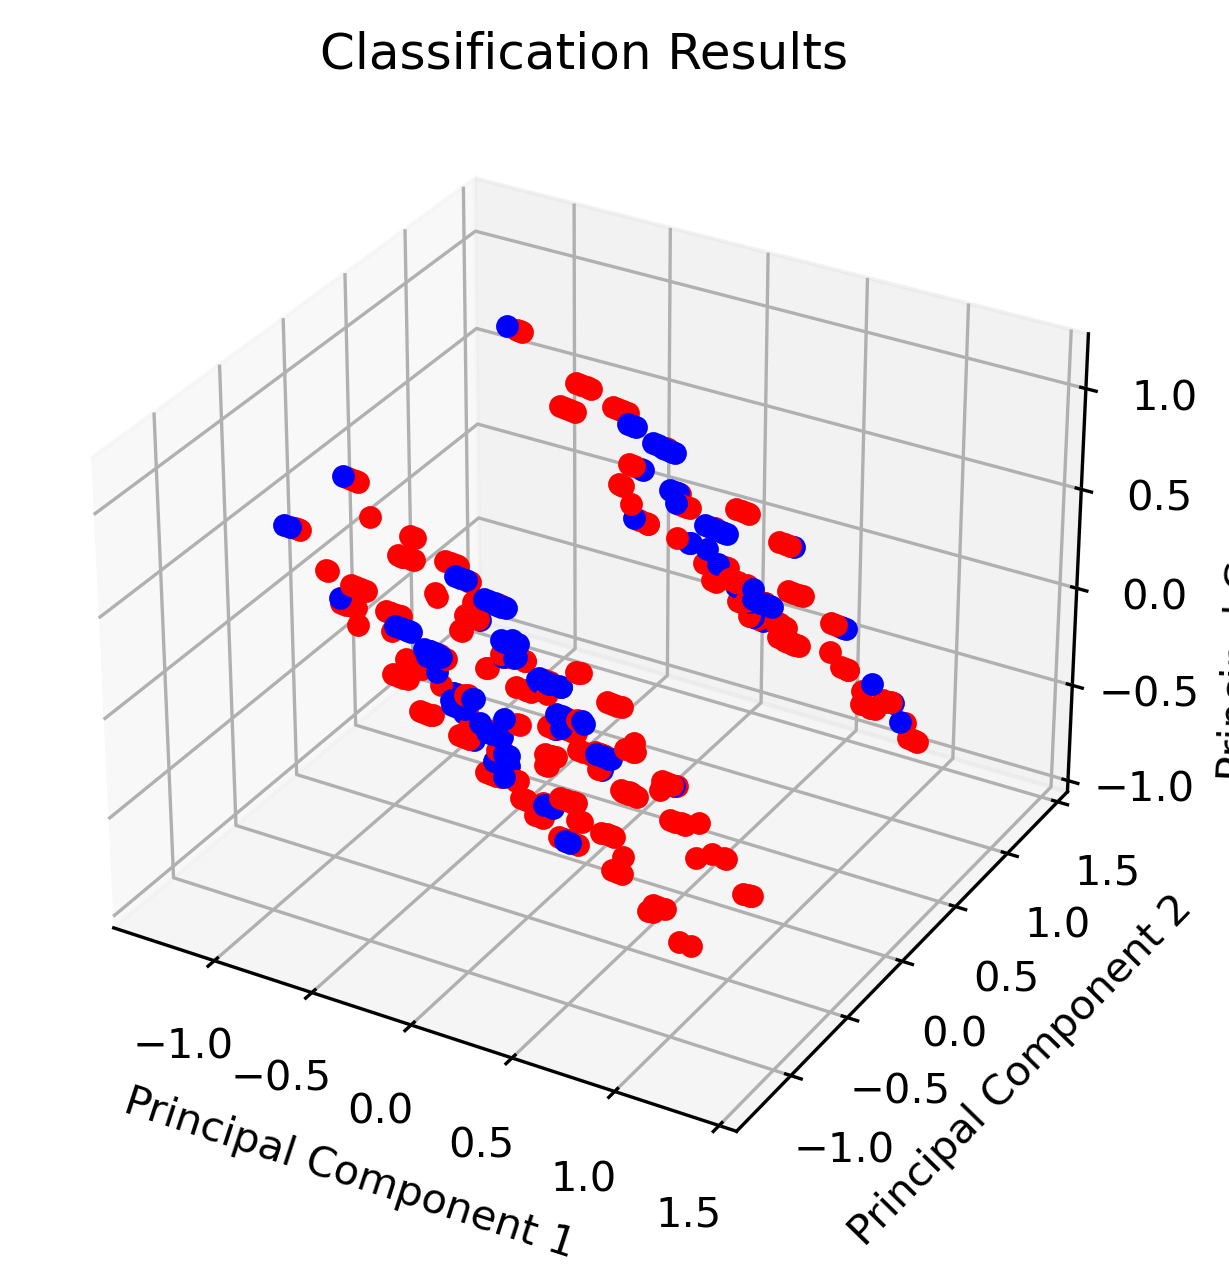

In [54]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 使用PCA将数据降维到3维
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

# 绘制三维图
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 绘制每个样本点
for i in range(X_train.shape[0]):
    if y_train[i] == 0:
        ax.scatter(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], c='r', label='Class 0')
    else:
        ax.scatter(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], c='b', label='Class 1')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Classification Results')
plt.savefig('pca.png')
plt.show()
# 其中散点表示训练数据在降维后的三个主成分上的投影。
# 不同类别的点用不同的颜色表示。通过这个图，您可以更好地理解数据的分布情况和符号分类器对分类任务的表现。
# PCA是一种常用的降维技术，在降维过程中，它会将原始数据通过线性变换转换为一组新的特征，称为主成分。
# 这些主成分按照其重要程度进行排序，第一个主成分即"Principal Component 1"对应的是解释原始数据方差最多的方向，第二个主成分即"Principal Component 2"对应的是解释剩余方差最多的方向，依此类推。因此，这些主成分代表了原始数据中的重要信息。
# 在三维空间中，我们可以使用这些降维后的主成分来表示样本点的位置。"Principal Component 1"表示样本在第一个主成分的投影，"Principal Component 2"表示样本在第二个主成分的投影，"Principal Component 3"表示样本在第三个主成分的投影。
# 通过在三维空间中绘制样本点的位置，您可以更好地观察到数据的分布情况以及分类结果。请记住，这些主成分是通过降维分析得到的，它们是原始数据的线性组合，可以用来解释数据的变异性。
# 数据的分布情况：您可以观察到数据点在三维空间中的分布情况。通过分析数据点的密度和聚集程度，您可以判断数据的结构和特征是否具有区分性。
# 类别的区分度：不同类别的数据点在三维空间中的分布情况可能不同。您可以观察到不同类别数据点的分离程度以及是否有重叠的情况。更好的分离和区分将意味着分类器的性能更好。
# 分类结果的可视化：您可以通过绘制分类结果的曲面或使用不同的颜色来表示不同的类别。这样可以直观地看到符号分类器对数据进行分类的效果。您可以观察到分类边界和分类错误的情况。

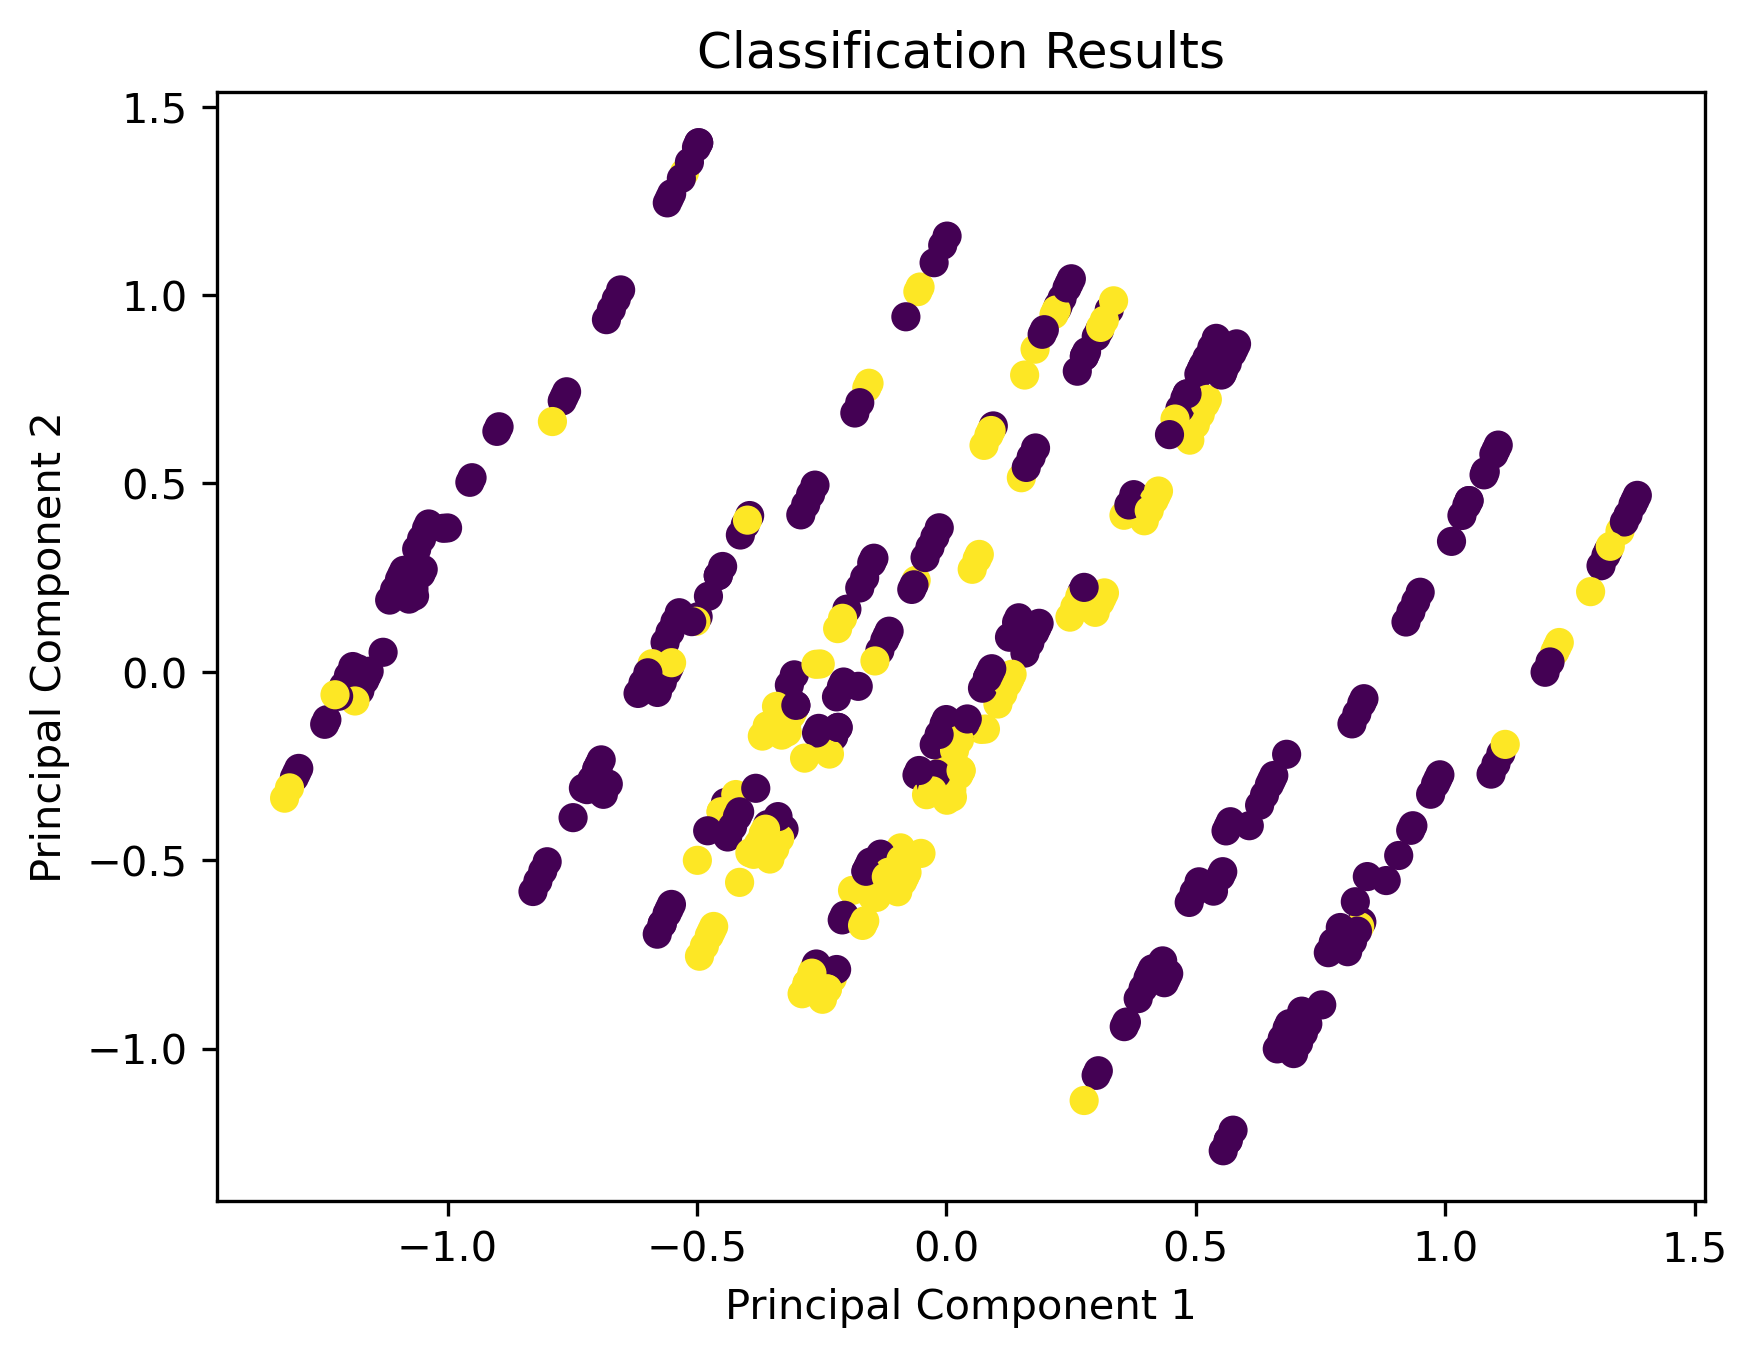

In [55]:
from sklearn.decomposition import PCA

# 使用PCA将数据降维到2维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# 绘制散点图
fig = plt.figure(dpi=300)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Classification Results')
plt.savefig('pca_2D.png')
plt.show()

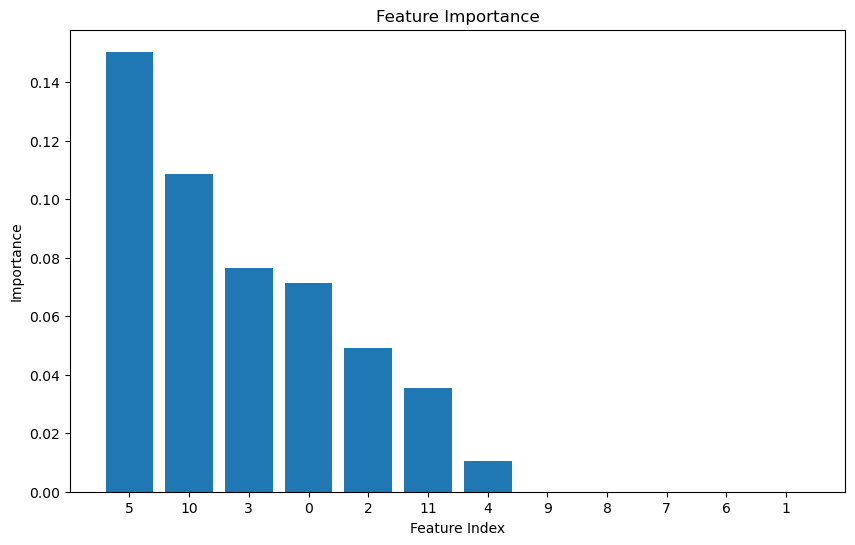

In [56]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 计算特征重要性
result = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=0)
feature_importance = result.importances_mean

# 排序并获取各特征的索引和重要性值
indices = np.argsort(feature_importance)[::-1]
sorted_importance = np.sort(feature_importance)[::-1]

# 绘制特征重要性条形图
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), sorted_importance, align="center")
plt.xticks(range(len(feature_importance)), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.savefig('Ranking_permutation_importance.png')
plt.show()
 


Feature 5: Ion Number of Shells
Feature 10: Ion Melting Point
Feature 3: X4 NumberofProtons
Feature 0: A1 NumberofProtons
Feature 2: X1 NumberofProtons
Feature 11: Ion Energy(ev)
Feature 4: Ion NumberofProtons
Feature 9: B Firstlonization
Feature 8: Ion AtomicRadius
Feature 7: Ion Density
Feature 6: Ion Specific Heat
Feature 1: B NumberofProtons


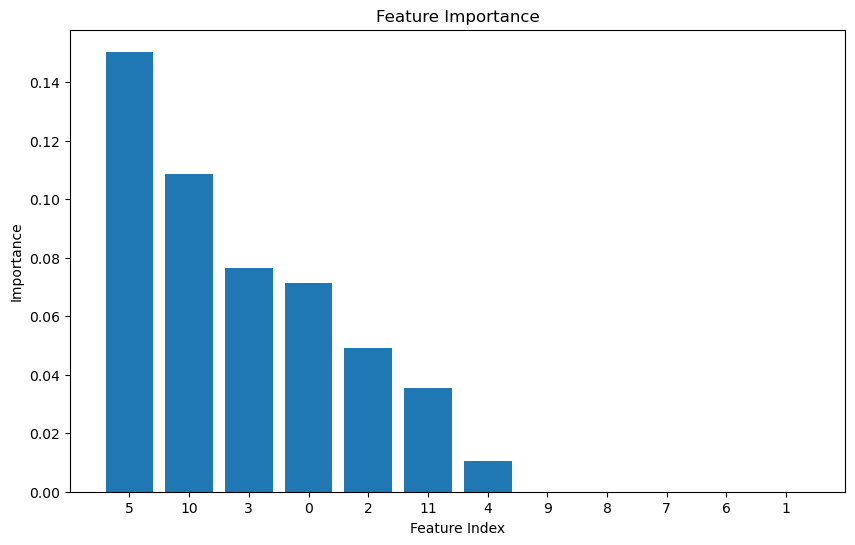

In [57]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 计算特征重要性
result = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=0)
feature_importance = result.importances_mean

# 排序并获取各特征的索引和重要性值
indices = np.argsort(feature_importance)[::-1]
sorted_importance = np.sort(feature_importance)[::-1]
 # Assuming X_train is a DataFrame with feature names

# 打印每个特征索引对应的列名
for index in indices:
    print(f"Feature {index}: {feature_names[index]}")

# # 绘制特征重要性条形图
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importance)), sorted_importance, align="center")
# plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices])  # Display feature names
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.title("Feature Importance")
# plt.savefig('有NLP的条形图.png')
# plt.show()
# 绘制特征重要性条形图
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), sorted_importance, align="center")
plt.xticks(range(len(feature_importance)), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.savefig('Ranking_permutation_importance2.png')
plt.show()
 

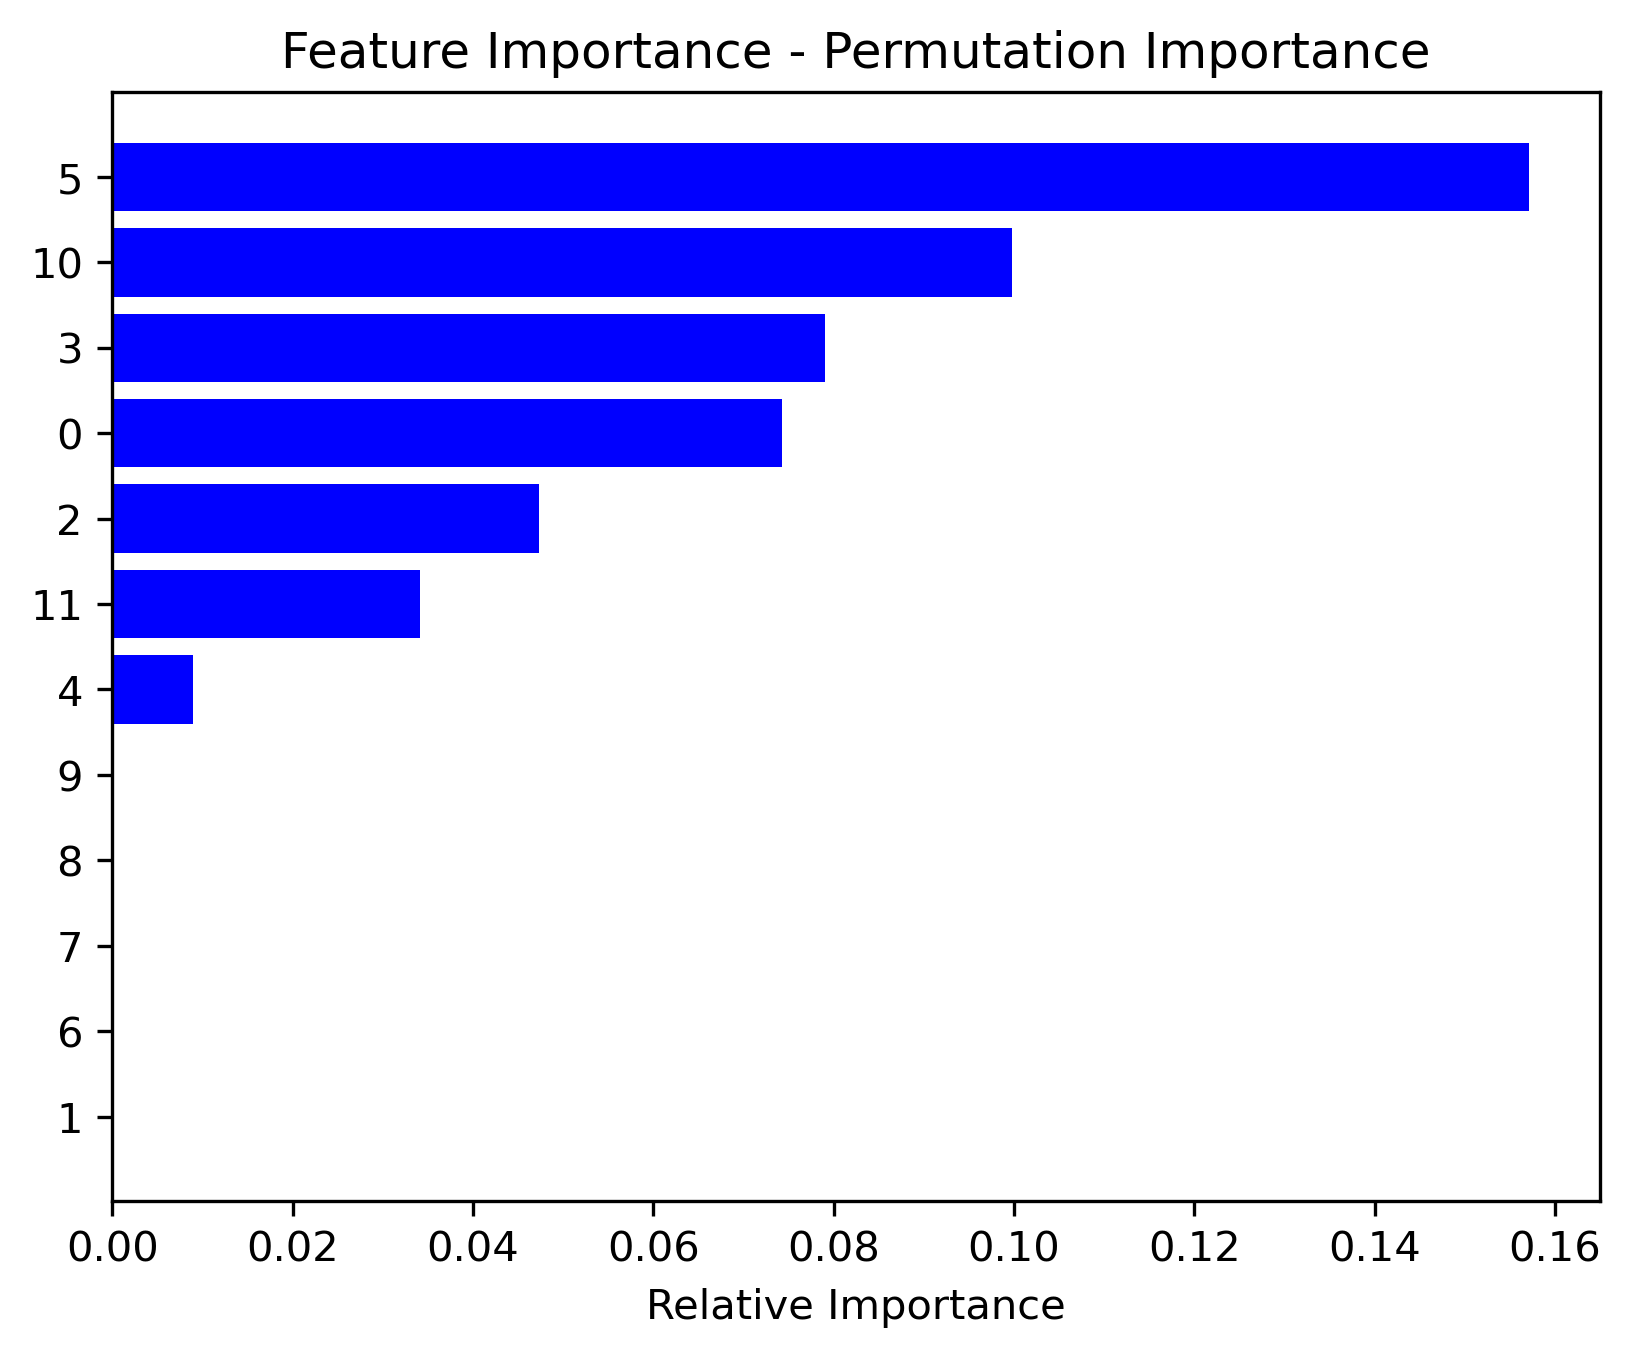

In [58]:
# Permutation Importance方法是一种近似的特征重要性度量，它对特征名称或具体数值并不敏感。
# 它只是通过随机排列来评估每个特征对模型的重要性。
# 因此，在该可视化中，特征对应的标签仅反映特征的索引，而不是实际的特征名称。

from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42)
importance = result.importances_mean
indices = np.argsort(importance)

plt.figure(dpi=300)
plt.title("Feature Importance - Permutation Importance")
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.savefig('Ranking_permutation_importance_1a.png')
plt.show()

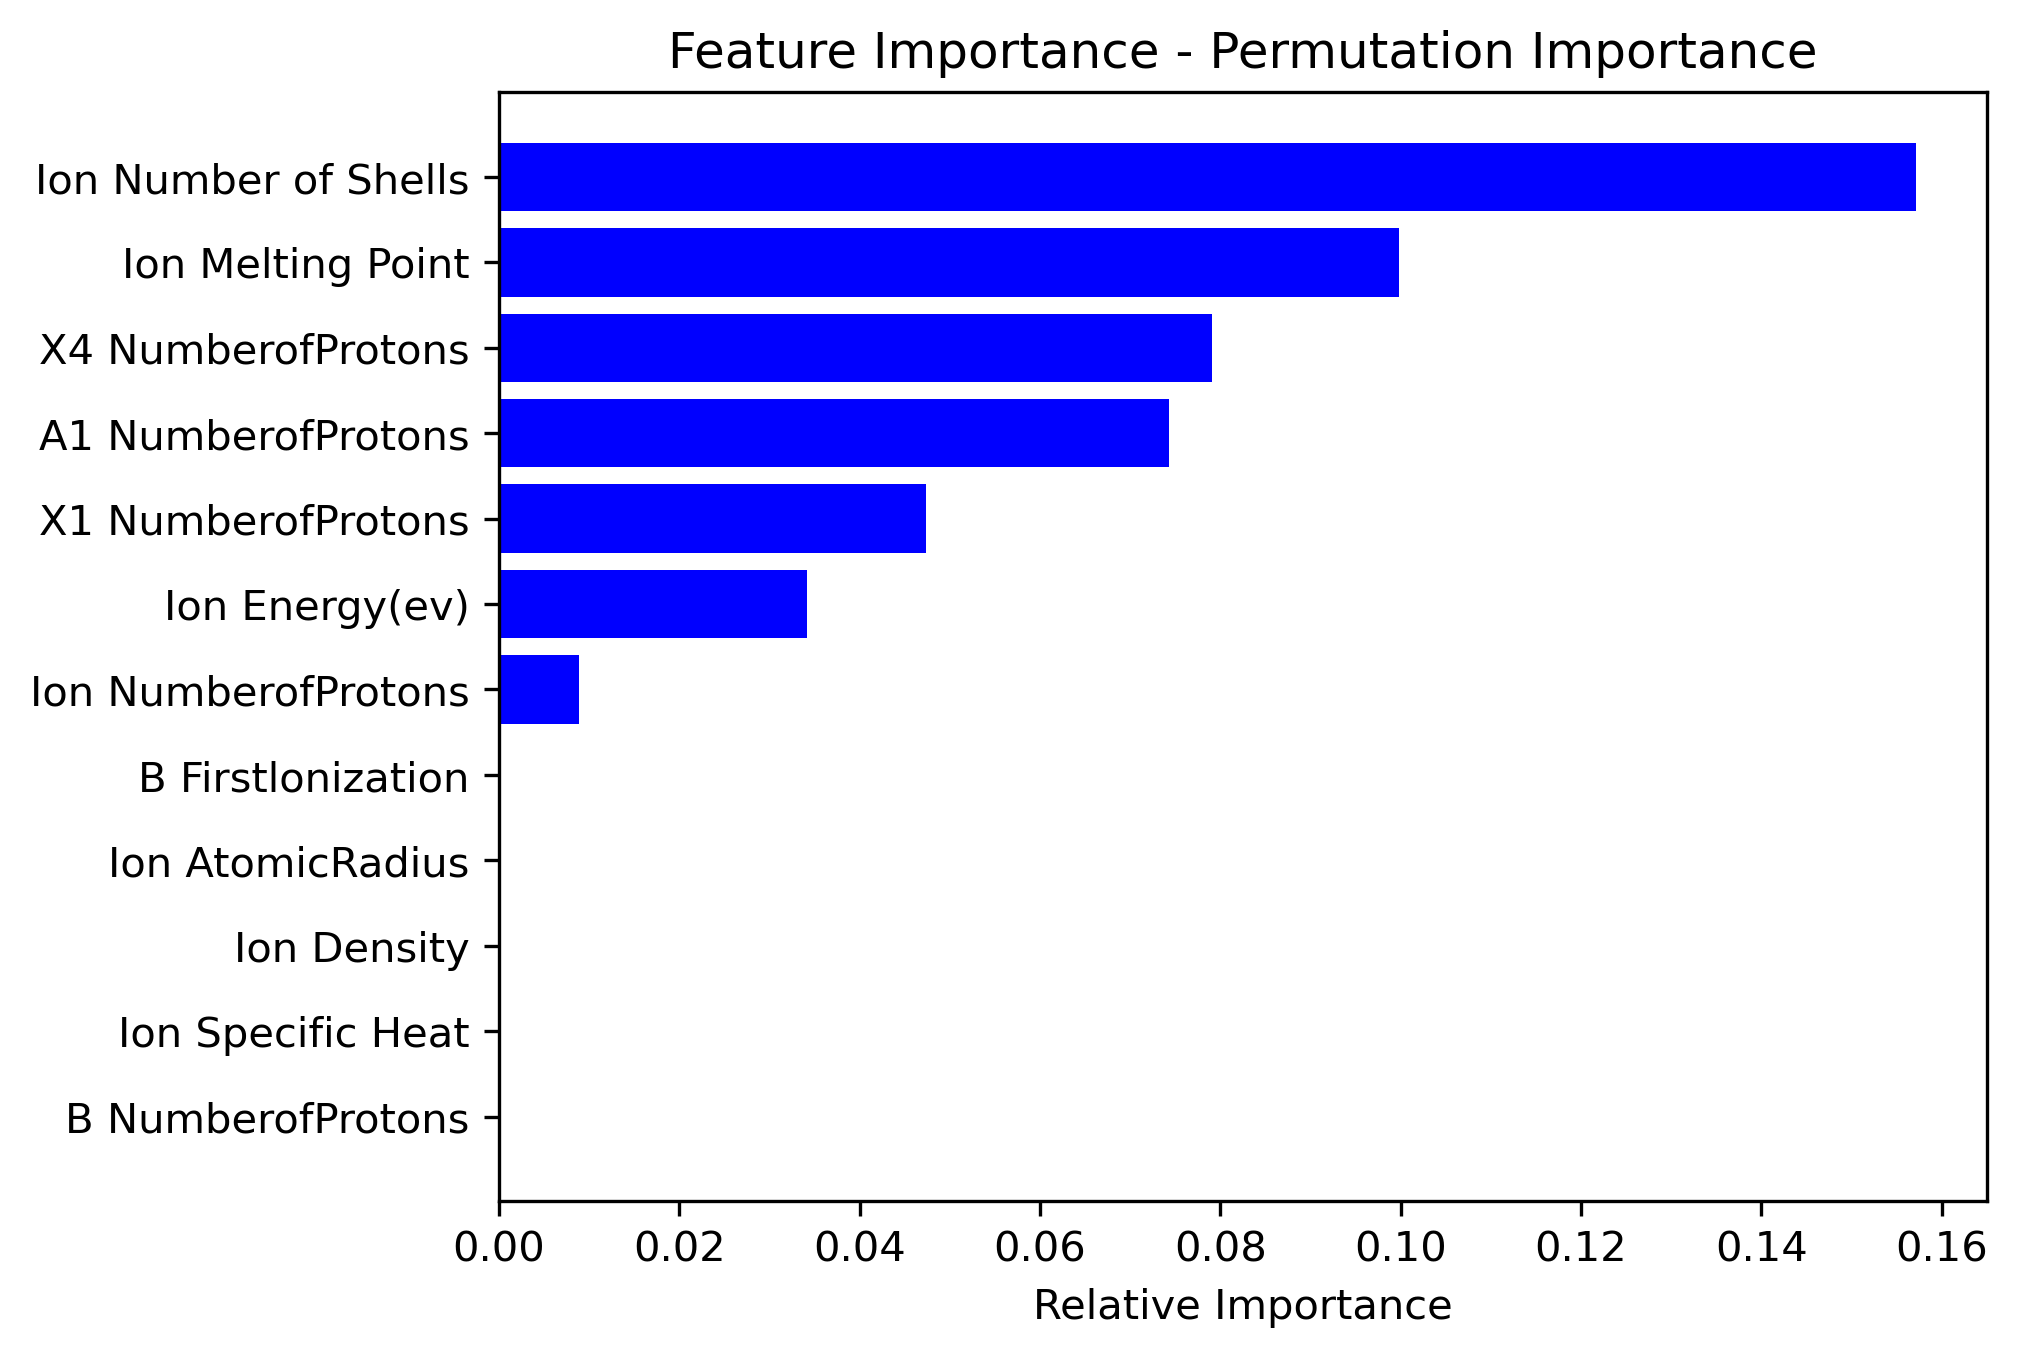

In [59]:
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42)
importance = result.importances_mean
indices = np.argsort(importance)
 # Convert feature names to a list

plt.figure(dpi=300)
plt.title("Feature Importance - Permutation Importance")
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])  # Display feature names as a list
plt.xlabel('Relative Importance')
plt.savefig('Ranking_permutation_importance_2a.png')
plt.show()

In [60]:
pickle.dump(reg,open("classification.dat","wb"))

In [61]:
pickle.dump(reg,open("reg.dat","wb"))

In [62]:
# prediction